In [1]:
from src.tools import *
from src.odes import *
from src.value_table import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_event(event, color, obj):
    count = 0
    start = int(integrator.tdata[0] + event.time)
    end = int(integrator.tdata[1]) + 1
    dt = int(event.repeat)
    dt = 1 if dt == 0 else dt
    for _ in range(start, end, dt):
        if count == 0:
            obj.axvline(_/3600, color=color, label=event.name)
            count += 1
            continue
        obj.axvline(_/3600, color=color)

# Helpers
To avoid repetition

In [3]:
def update_integrator(ode, **kwargs):
    kwargs['ics'][ode.notation] = ode.state
    kwargs['params'][f'{ode.notation}_rate'] = ode.rate

In [4]:
def update_rate(ode, **kwargs):
    ode.state = kwargs['c_step']['points'][ode.notation][-1]
    ode.dy_dt(t=kwargs['t'][-1])

## Callbacks
Are  attached to events, and are responsible for updating various simulation parameters, e.g environment temperature, window opening etc

In [5]:
def clb_env_temp(**kwargs):
    env.state = env.compute_temp(t=kwargs['t'][-1])
    env.dy_dt(t=kwargs['t'][-1])
    # print('rate env', env.rate)
    #update_rate(ode=radiator, **kwargs)
    update_integrator(ode=env, **kwargs)

In [6]:
def clb_get_rates(**kwargs):
    window_rate.set_state(int(room.open))
    update_integrator(ode=window_rate, **kwargs)

    opening_rate.set_state(radiator.opening())
    update_integrator(ode=opening_rate, **kwargs)

In [7]:
def clb_log_callback(**kwargs):
    time_ = kwargs['c_step']['points']['t'][-1]
    print([time_/3600, time_, integrator.tdata[-1]])

In [8]:
def clb_wanted_temp_callback(**kwargs):
    update_integrator(ode=wanted_temperature, **kwargs)

In [9]:
def clb_radiator_temp(**kwargs):
    update_rate(ode=radiator, **kwargs)
    update_integrator(ode=radiator, **kwargs)

In [10]:
def clb_room_temp(**kwargs):
    update_rate(ode=room, **kwargs)
    update_integrator(ode=room, **kwargs)

In [11]:
def clb_wake_up(**kwargs):
    wanted_temperature.set_state(state=TEMP_DAY_NOMINAL)
    radiator.tempNominal = TEMP_DAY_NOMINAL
    update_integrator(ode=radiator, **kwargs)

In [12]:
def clb_sleep(**kwargs):
    wanted_temperature.set_state(state=TEMP_NIGHT_NOMINAL)
    radiator.tempNominal = TEMP_NIGHT_NOMINAL
    update_integrator(ode=radiator, **kwargs)

In [13]:
def open_close_window_event(start, duration=None):
    duration = np.random.randint(1, 8)/10 if duration is None else duration
    duration += start
    open_window = Event(name='open_window_event', time=start, repeat=None)
    close_window = Event(name='close_window_event', time=duration, repeat=None)
    open_window.attach_callback(func=lambda **kwargs: room.set_open(open=True))
    close_window.attach_callback(func=lambda **kwargs: room.set_open(open=False))
    return open_window, close_window

# Events
Stops the integration process and executes any attached callback function

In [14]:
main_event = Event(name='main_event', time=0 * TimeUnits.second, repeat=0.2 * TimeUnits.minute, term=True, active=True)
wake_up_event = Event(name='wake_up_event', time=7 * TimeUnits.hour, repeat=24*TimeUnits.hour)
go_to_sleep_event = Event(name='go_to_sleep_event', time=22 * TimeUnits.hour, repeat=24*TimeUnits.hour)

In [15]:
# The main event stops the integration process and updates the simulation parameters
main_event.attach_callback(func=clb_env_temp)
main_event.attach_callback(func=clb_get_rates)
#main_event.attach_callback(func=clb_log_callback)
main_event.attach_callback(func=clb_wanted_temp_callback)
main_event.attach_callback(func=clb_room_temp)
main_event.attach_callback(func=clb_radiator_temp)
# This event sets the wanted temperature when the resident wakes up
wake_up_event.attach_callback(func=clb_wake_up)
# This event sets the wanted temperature when the resident goes to sleeps
go_to_sleep_event.attach_callback(func=clb_sleep)

# Experimentation Variables

In [16]:
TEMP_NIGHT_NOMINAL = 15
TEMP_DAY_NOMINAL = 22
EXPERIMENT_DURATION = 2*TimeUnits.day

# Integrator

In [17]:
integrator = Integrator(
    tdata=[0, EXPERIMENT_DURATION],
    max_step=10 * TimeUnits.minute,
    min_step=0.0001 * TimeUnits.minute,
    init_step=10*TimeUnits.second,
    expressions={**room.expr, **radiator.expr, **env.expr, **boiler.expr, **window_rate.expr, **wanted_temperature.expr, **opening_rate.expr},
    ics={**room.ics, **radiator.ics, **env.ics, **boiler.ics, **window_rate.ics, **wanted_temperature.ics, **opening_rate.ics},
    events=[
        main_event,
        wake_up_event,
        go_to_sleep_event,
        *open_close_window_event(start=7.35*TimeUnits.hour, duration=0.35*TimeUnits.hour),
        *open_close_window_event(start=15.7*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=17*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=18.2*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=20.9*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=22*TimeUnits.hour, duration=0.25*TimeUnits.hour),
        *open_close_window_event(start=(24 + 17)*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=(24 + 18.2)*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=(24 + 20.9)*TimeUnits.hour, duration=0.3*TimeUnits.hour),
        *open_close_window_event(start=(24 + 22)*TimeUnits.hour, duration=0.25*TimeUnits.hour),
    ],
    params={
        'env_rate': env.dy_dt(t=0),
        'room_rate': room.dy_dt(t=0),
        'radiator_rate': radiator.dy_dt(t=0),
        'boiler_rate': boiler.dy_dt(t=0),
        'window_rate': window_rate.dy_dt(t=0),
        'wanted_rate': wanted_temperature.dy_dt(t=0),
        'opening_rate': opening_rate.dy_dt(t=0),
    }
)
integrator.verbose = 1

# Solver

In [18]:
env.refresh_value_table() # Ensures the value table is not empty
with timer() as f:  # Takes about 4 minutes to finish...
    results = integrator.solve(debug=False)

duration: 116.8s


# Results

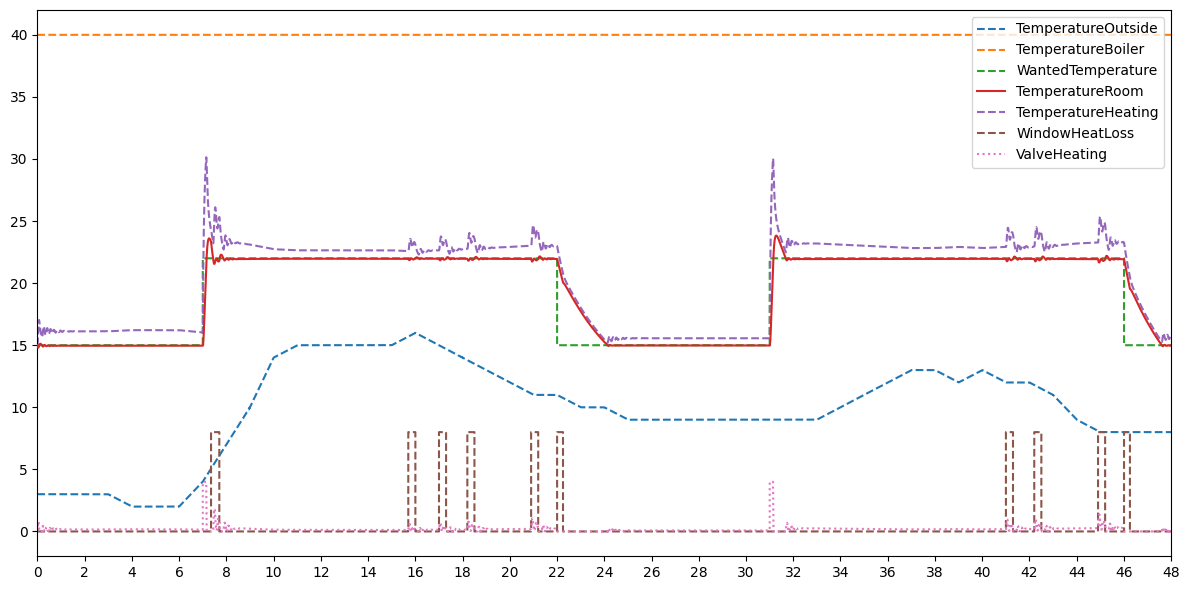

In [19]:
num = int(TimeUnits.hour) * 24
if results is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(results['t']/3600, results['env'], '--', label='TemperatureOutside')
    plt.plot(results['t']/3600, results['boiler'], '--', label='TemperatureBoiler')
    plt.plot(results['t']/3600, results['wanted'], '--', label='WantedTemperature')
    plt.plot(results['t']/3600, results['room'], '-', label='TemperatureRoom', zorder=10)
    plt.plot(results['t']/3600, results['radiator'], '--', label='TemperatureHeating')
    plt.plot(results['t']/3600, results['window'] * 8, '--', label='WindowHeatLoss')
    plt.plot(results['t']/3600, results['opening'] * 4, ':', label='ValveHeating')
    plt.xlim(0, 24*2)
    plt.xticks(range(0, 25*2, 2))
    plt.yticks(range(0, 45, 5))
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Format and export the results

In [20]:
data = [
    *zip(
        results['t']/3600,
        results['env'], 
        results['boiler'],
        results['wanted'],
        results['room'],
        results['radiator'],
        results['window']*7,
        results['opening']*3,
    )
]
with open('gnuplot/data.dat', 'w') as f:
    for _ in data:
        f.write(('{} '*len(_)).format(*_))
        f.write('\n')

# Gnuplot

In [21]:
!gnuplot gnuplot/script.gp